In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

from collections import defaultdict

import t3nsor as t3

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from argparse import Namespace
import tqdm.notebook

from sample import Sampler
from models import *
from metric import accuracy, roc_auc_compute_fn

In [2]:
history_path = "../DropEdge/runs/run_history-dataset_citeseer-type_mutigcn"
history_df = pd.read_csv(history_path)
history_df.head()

,Unnamed: 0,loss_train,acc_train,loss_val,acc_val,cur_lr,s_time,t_time,v_time
0,0,2.163904,0.174945,1.797721,0.176,0.009,0.002554,0.151374,0.066240
1,1,2.154949,0.169978,1.787375,0.178,0.009,0.002818,0.148917,0.045730
2,2,2.145338,0.164459,1.785773,0.182,0.009,0.002452,0.142773,0.067224
3,3,2.101136,0.178808,1.785241,0.180,0.009,0.002890,0.148884,0.061545
4,4,2.099121,0.179360,1.786227,0.180,0.009,0.002849,0.130185,0.051867


Text(0, 0.5, 'accuracy')

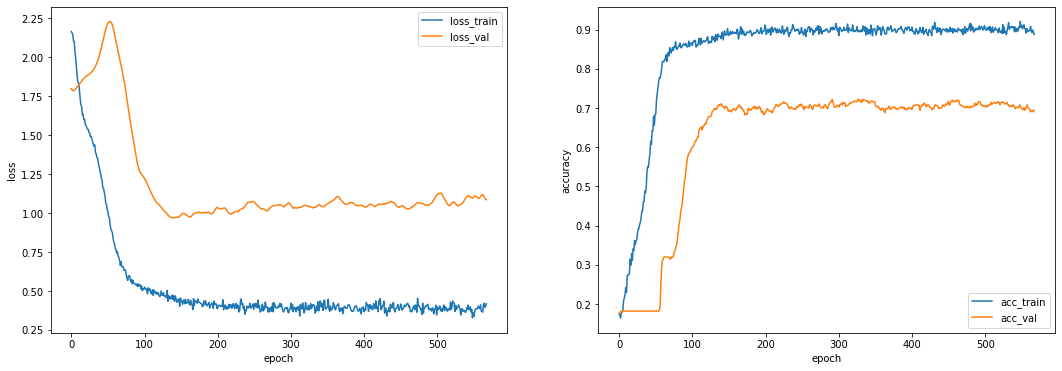

In [3]:
fig,axs = plt.subplots(1, 2, figsize=(18, 6))

history_df[['loss_train', 'loss_val']].plot(ax=axs[0])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

history_df[['acc_train', 'acc_val']].plot(ax=axs[1])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')

In [4]:
model_path = "../DropEdge/tmpmodel/tmp-0213-101527-VQp.pt"
args_path = "../DropEdge/tmpmodel/args.json"

with open(args_path, 'r') as f:
    args = json.loads(f.read())
    print("args: ", args)
    args = Namespace(**args)

args.datapath = '../DropEdge/' + args.datapath
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

sampler = Sampler(args.dataset, args.datapath, args.task_type)
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(args.cuda)
nfeat = sampler.nfeat
nclass = sampler.nclass

base_model = GCNModel(nfeat=nfeat,
                      nhid=args.hidden,
                      nclass=nclass,
                      nhidlayer=args.nhiddenlayer,
                      dropout=args.dropout,
                      baseblock=args.type,
                      inputlayer=args.inputlayer,
                      outputlayer=args.outputlayer,
                      nbaselayer=args.nbaseblocklayer,
                      activation=F.relu,
                      withbn=args.withbn,
                      withloop=args.withloop,
                      aggrmethod=args.aggrmethod,
                      mixmode=args.mixmode)

if device == torch.device('cuda'):
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    
base_model.load_state_dict(state_dict)
base_model.to(device)

args:  {'no_cuda': False, 'fastmode': False, 'seed': 42, 'epochs': 1000, 'lr': 0.009, 'lradjust': False, 'weight_decay': 0.001, 'mixmode': False, 'warm_start': '', 'debug': True, 'dataset': 'citeseer', 'datapath': 'data//', 'early_stopping': 400, 'no_tensorboard': False, 'type': 'mutigcn', 'inputlayer': 'gcn', 'outputlayer': 'gcn', 'hidden': 256, 'dropout': 0.8, 'withbn': True, 'withloop': True, 'nhiddenlayer': 1, 'normalization': 'BingGeNormAdj', 'sampling_percent': 0.05, 'nbaseblocklayer': 3, 'aggrmethod': 'nores', 'task_type': 'full', 'cuda': False}
Load full supervised task.


/home/ms/Learning/svd4gcn/DropEdge/src/normalization.py:110: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


GCNModel(
  (ingc): GraphConvolutionBS(
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outgc): GraphConvolutionBS(
    (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (midlayer): ModuleList(
    (0): MultiLayerGCNBlock(
      (model): GraphBaseBlock(
        (hiddenlayers): ModuleList(
          (0): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
    )
  )
)

In [5]:
class GraphConvolutionTTLinear(Module):
    def __init__(self, orig_layer, tt_rank, d=3, auto_shape_criterion='entropy', auto_shape_mode='ascending'):
        super(GraphConvolutionTTLinear, self).__init__()
        self.tt_rank = tt_rank
        
        in_quantization = t3.utils.auto_shape(
            orig_layer.in_features, d=d, criterion=auto_shape_criterion, mode=auto_shape_mode)
        out_quantization = t3.utils.auto_shape(
            orig_layer.out_features, d=d, criterion=auto_shape_criterion, mode=auto_shape_mode)

        self.tt_raw_shape = [in_quantization, out_quantization]
        self.tt_weight = t3.decompositions.to_tt_matrix(
            orig_layer.weight,
            self.tt_raw_shape,
            self.tt_rank
        )
        
        if orig_layer.self_weight is not None:
            self.self_tt_weight = t3.decompositions.to_tt_matrix(
                orig_layer.self_weight,
                self.tt_raw_shape,
                self.tt_rank
            )
        else:
            self.register_parameter('self_tt_weight', None)
        
        
        self.bn = orig_layer.bn
        self.bias = orig_layer.bias
        self.sigma = orig_layer.sigma
        self.res = orig_layer.res
        
        self.in_features = orig_layer.in_features
        self.out_features = orig_layer.out_features

    def forward(self, _input, adj):
        support = t3.dense_tt_matmul(_input, self.tt_weight)
        output = torch.spmm(adj, support)
        
        if self.self_tt_weight is not None:
            output = output + t3.dense_tt_matmul(_input, self.self_tt_weight)
        
        if self.bias is not None:
            output = output + self.bias
            
        if self.bn is not None:
            output = self.bn(output)
            
        if self.res:
            return self.sigma(output) + input
        else:
            return self.sigma(output)
        
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) \
               + ', ' + str(self.tt_rank) + ')'

In [6]:
# in_f = base_model.ingc.in_features
# out_f = base_model.ingc.out_features
# a = base_model.ingc.weight
# b = torch.rand(out_f, in_f)
    
# results = []
# for d in [3, 4, 5]:
#     for tt_rank in [10, 50, 100, 200]:
#     #     d = 3
#     #     tt_rank = 3
#         in_quantization = t3.utils.auto_shape(
#             in_f, d=d, criterion='entropy', mode='ascending')
#         out_quantization = t3.utils.auto_shape(
#             out_f, d=d, criterion='entropy', mode='ascending')

#         tt_raw_shape = [in_quantization, out_quantization]

#         tt_weight = t3.decompositions.to_tt_matrix(
#             a,
#             tt_raw_shape,
#             tt_rank
#         )
#         difl2norm = torch.norm(torch.matmul(b, a) - t3.dense_tt_matmul(b, tt_weight))
# #         print(f"d: {d}; tt_rank: {tt_rank}; difl2norm: {difl2norm};")
#         results.append(
#             (d, tt_rank, difl2norm.item())
#         )

# sorted(results, key=lambda x: x[2])

In [7]:
def test(model, test_adj, test_fea):
    model.to(device)
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args.normalization,
    cuda= device == torch.device('cuda')
)

In [8]:
# base_model.to(device)
base_loss_test, base_acc_test = test(base_model, test_adj, test_fea)
# base_model.cpu()
print(f"Loss test on base_model = {base_loss_test}\nAcc test of base_model = {base_acc_test}")

Loss test on base_model = 0.8044756650924683
Acc test of base_model = 0.758


In [9]:
import copy

def make_new_model(model, r, d=3):
    new_model = copy.deepcopy(model)
    new_model.ingc = GraphConvolutionTTLinear(new_model.ingc, r, d)
    new_model.to(device)
    return new_model

In [10]:
model = make_new_model(base_model, 120, 3)
loss_test, acc_test = test(model, test_adj, test_fea)
print(loss_test, acc_test)

0.9859527349472046 0.68


In [13]:
tt_ranks = np.arange(30, 121, 5, dtype=np.int32)
ds = np.arange(2, 4, dtype=np.int32)
accs = np.zeros((len(tt_ranks), len(ds)))
losses = np.zeros((len(tt_ranks), len(ds)))
for i, tt_rank in tqdm.notebook.tqdm(enumerate(tt_ranks), total=len(tt_ranks)):
    for j, d in enumerate(ds):
        model = make_new_model(base_model, int(tt_rank), int(d))
        loss_test, acc_test = test(model, test_adj, test_fea)
        accs[i, j] = acc_test
        losses[i, j] = loss_test
        del model

Text(33.0, 0.5, 'tt rank')

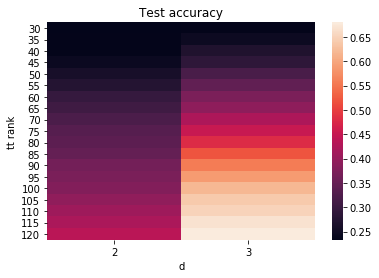

In [16]:
ax = plt.axes()
sns.heatmap(accs,
            xticklabels=ds,
            yticklabels=tt_ranks,
            annot=False,
            ax=ax)

ax.set_title('Test accuracy')
ax.set_xlabel('d')
ax.set_ylabel('tt rank')

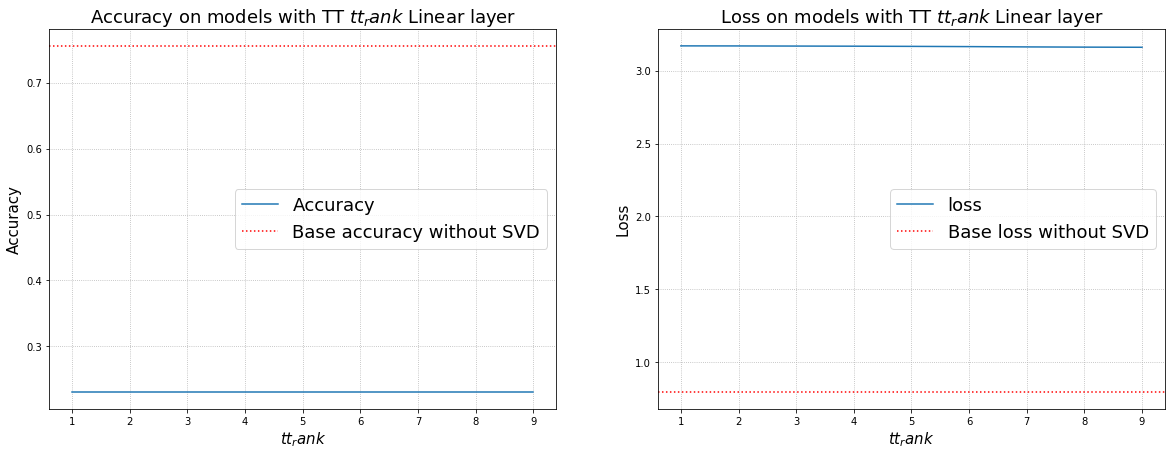

In [11]:
# fig,axs = plt.subplots(1, 2)
# fig.set_size_inches(20, 7)

# axs[0].plot(experiments['tt_rank'], experiments['acc'], label='Accuracy')
# axs[0].axhline(y=base_acc_test, color='r', linestyle=':', label="Base accuracy without SVD")
# axs[0].legend(fontsize=18)
# axs[0].set_title("Accuracy on models with TT $tt_rank$ Linear layer", fontsize=18)
# axs[0].set_ylabel("Accuracy", fontsize=15)
# axs[0].set_xlabel("$tt_rank$", fontsize=15)
# axs[0].grid(ls=":")

# axs[1].plot(experiments['tt_rank'], experiments['loss'], label='loss')
# axs[1].axhline(y=base_loss_test, color='r', linestyle=':', label="Base loss without SVD")
# axs[1].legend(fontsize=18)
# axs[1].set_title("Loss on models with TT $tt_rank$ Linear layer", fontsize=18)
# axs[1].set_ylabel("Loss", fontsize=15)
# axs[1].set_xlabel("$tt_rank$", fontsize=15)
# axs[1].grid(ls=":")